<div class="alert alert-block alert-success">
    <h1 align="center">Imbalanced Datasets Trick</h1>
    <h3 align="center">Resampling strategies for imbalanced datasets</h3>
    <h4 align="center"><a href="http://www.iran-machinelearning.ir">Soheil Tehranipour</a></h5>
</div>

<img src = "photo1.PNG" width=60%>

<h2 style="margin-bottom: 18px">Index</h2>

* Imbalanced datasets
* The metric trap
* Resampling
* Random under-sampling
* Random over-sampling
* Python imbalanced-learn module
* Random under-sampling and over-sampling with imbalanced-learn
* Under-sampling: Tomek links
* Over-sampling: SMOTE
* Over-sampling followed by under-sampling
* Recommended reading

<h2 id="t1" style="margin-bottom: 18px">Imbalanced datasets</h2>

In this kernel we will know some techniques to handle highly unbalanced datasets, with a focus on resampling. The Porto Seguro's Safe Driver Prediction competition, used in this kernel, is a classic problem of unbalanced classes, since insurance claims can be considered unusual cases when considering all clients. Other classic examples of unbalanced classes are the detection of financial fraud and attacks on computer networks.

Link to the dataset:
https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/overview

Let's see how unbalanced the dataset is:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import imblearn

C:\Users\soso\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Class 0: 573518
Class 1: 21694
Proportion: 26.44 : 1


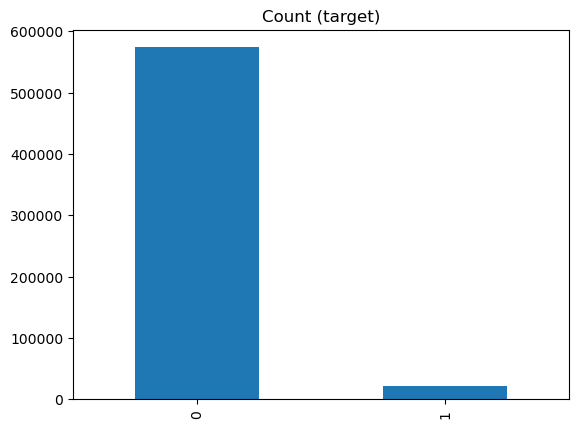

In [2]:
df_train = pd.read_csv('train.csv')

target_count = df_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [3]:
df_train.head(1)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1


<h2 id="t2" style="margin-bottom: 18px">The metric trap</h2>

One of the major issues that novice users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like <code>accuracy_score</code> can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Let's do this experiment, using simple cross-validation and no feature engineering:

In [4]:
# Remove 'id' and 'target' columns
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\Users\soso\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\soso\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:21:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 96.35%


Now let's run the same code, but using only one feature (which should drastically reduce the accuracy of the classifier):

In [5]:
model = XGBClassifier()
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[16:22:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\soso\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\soso\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Accuracy: 96.36%


As we can see, the high accuracy rate was just an illusion. In this way, the choice of the metric used in unbalanced datasets is extremely important. In this competition, the evaluation metric is the Normalized Gini Coefficient, a more robust metric for imbalanced datasets, that ranges from approximately 0 for random guessing, to approximately 0.5 for a perfect score.

<h2 id="t4" style="margin-bottom: 18px">Resampling</h2>

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

Let's implement a basic example, which uses the <code>DataFrame.sample</code> method to get random samples each class:

In [6]:
# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

<h2 id="t5">Random under-sampling</h2>

* Random undersampling randomly deletes records from the majority class. You should consider trying this technique when you have a lot of data.

A simple undersampling technique is to undersample the majority class randomly and uniformly. This can potentially lead to information loss, though. But if the examples of the majority class are near to others in terms of distance, this method might yield good results.

<img src = "UnderSampling.png" width=70%>

Random under-sampling:
0    21694
1    21694
Name: target, dtype: int64


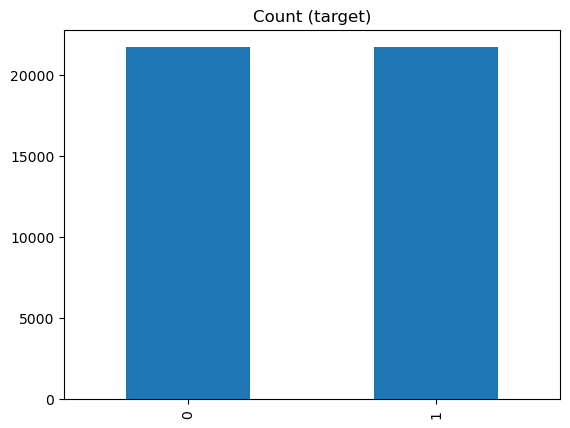

In [7]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

<h2 id="t6">Random over-sampling</h2>

Random oversampling randomly duplicate records from the minority class. Try this technique when you don’t have a lot of data.

Random oversampling simply replicates random minority class examples. It’s known to increase the likelihood of overfitting, which is a major drawback.

<img src = "OverSampling.png" width=70%>

Random over-sampling:
0    573518
1    573518
Name: target, dtype: int64


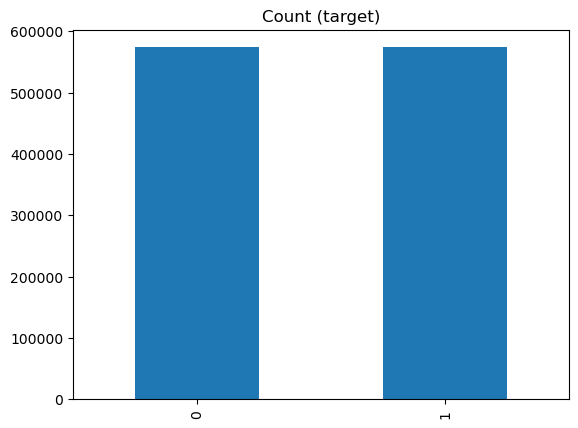

In [8]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

### Disadvantages
Notwithstanding the advantage of balancing classes, these techniques also have some drawbacks:

If you duplicate random records from the minority class to do oversampling, this will cause overfitting.
By undersampling and removing random records from the majority class, you risk losing some important information for the machine learning algorithm to use while training and predicting.

<h2 id="t7" style="margin-bottom: 18px">Python imbalanced-learn module</h2>

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library [imbalanced-learn](https://imbalanced-learn.org).

For ease of visualization, let's create a small unbalanced sample dataset using the <code>make_classification</code> method:

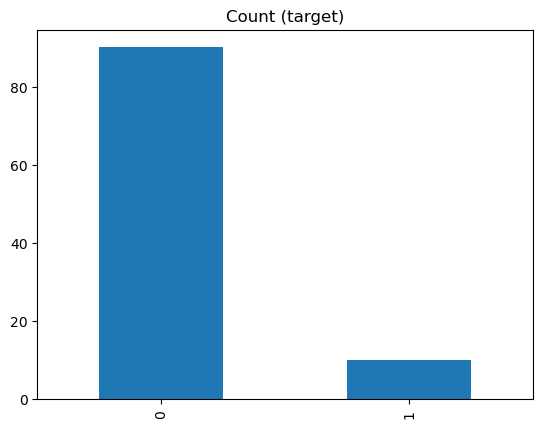

In [9]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

We will also create a 2-dimensional plot function, <code>plot_2d_space</code>, to see the data distribution:

In [10]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

Because the dataset has many dimensions (features) and our graphs will be 2D, we will reduce the size of the dataset using Principal Component Analysis (PCA):

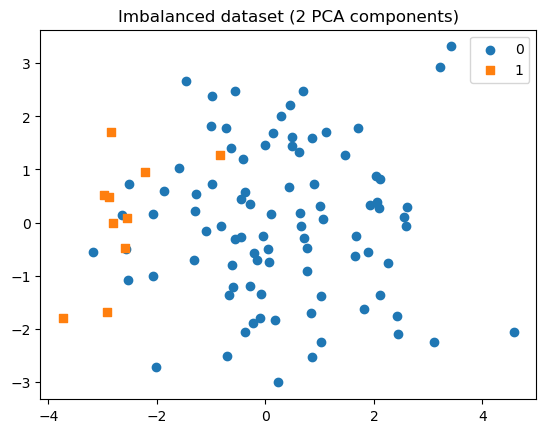

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

<h2 id="#t72">Random under-sampling and over-sampling with imbalanced-learn</h2>

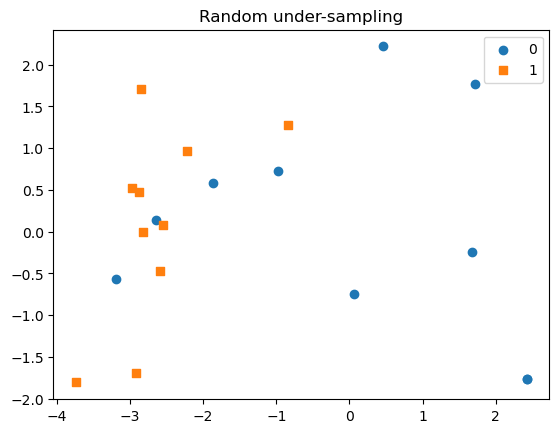

In [12]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=True)
X_rus, y_rus = rus.fit_resample(X, y)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

* sampling_strategy : This parameter can be used to tell the object how to perform undersampling on our dataset. It can be majority to resample only the majority class, not_minority to resample all classes but the minority class, and auto is the default one here, which stands for not_minority. You can check out the documentation (included below in “Resources”) to learn more.
* return_indices : Boolean on whether to return the indices of the removed instances or not.
* random_state : An integer that controls the randomness of the procedure, allowing you to reproduce the results.

80 new random picked points


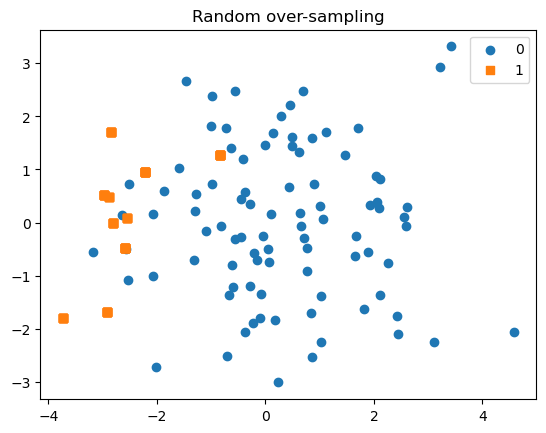

In [13]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

In [14]:
y.shape

(100,)

In [15]:
y_ros.shape

(180,)

In [16]:
X_ros

array([[ 0.17745104, -1.83646187],
       [ 0.48334862,  1.44135941],
       [-0.28203452, -1.19199943],
       [-0.63056485,  1.41117742],
       [-2.54661668,  0.07664698],
       [-2.52908894, -1.09239392],
       [-1.00025597,  1.81970329],
       [-2.0229804 , -2.72605005],
       [-2.91676826, -1.69253484],
       [-0.84399458,  1.2748164 ],
       [-0.60981014, -0.80454728],
       [ 2.02999659,  0.86791168],
       [ 0.09750093,  0.15550449],
       [-0.10873544, -1.80630362],
       [-2.81687964, -0.00491207],
       [-0.68017965, -1.35671263],
       [-2.221968  ,  0.96074098],
       [ 1.0138328 ,  0.30191965],
       [ 1.03007313, -1.38625376],
       [ 2.60496404,  0.29357503],
       [-0.45315449,  0.44906397],
       [ 0.61547258,  1.33795531],
       [ 0.86488853,  1.58770896],
       [-1.32107149, -0.71351953],
       [-0.56817392, -0.3086317 ],
       [ 0.42775385,  0.66260292],
       [ 1.88507801, -0.56332997],
       [ 0.06366303, -0.74718566],
       [ 1.06724797,

In [17]:
X.shape

(100, 2)

In [18]:
X_ros.shape

(180, 2)

In [19]:
y_ros.shape

(180,)

<h2 id="t8" style="margin-bottom: 18px">Under-sampling: Tomek links</h2>

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/tomek.png?v=2)

* Tomek links are pairs of very close instances that belong to different classes. They’re samples near the borderline between classes. By removing the examples of the majority class of each pair, we increase the space between the two classes and move toward balancing the dataset by deleting those points.

In the code below, we'll use <code>sampling_strategy='majority'</code> to resample the majority class.

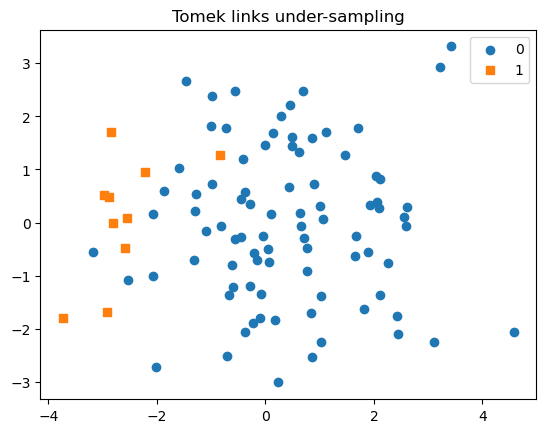

In [20]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

<img src = "SMOTE.png">

<h2 id="t10" style="margin-bottom: 18px">Over-sampling: SMOTE</h2>

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

 ![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

We'll use <code>sampling_strategy='minority'</code> to resample the minority class.

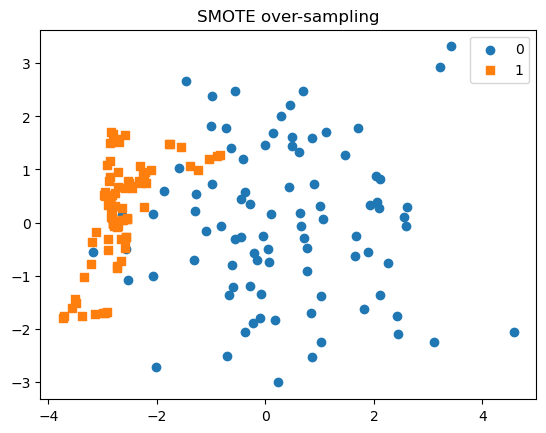

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

<img src = "SMOTE2.png">

<h2 id="t11" style="margin-bottom: 18px">Over-sampling followed by under-sampling</h2>

Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:

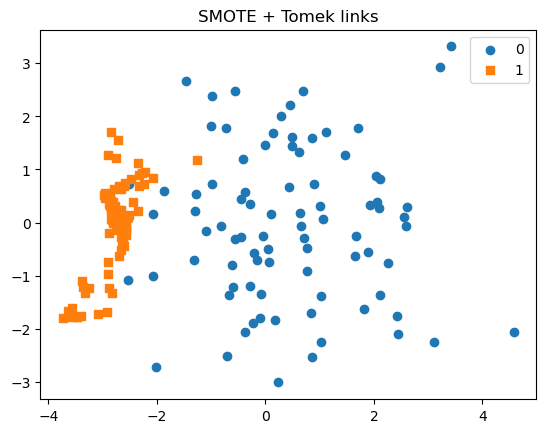

In [22]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_resample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

## ADASYN Oversampling
ADASYN stands for Adaptive Synthetic sampling, and as SMOTE does, ADASYN generates samples of the minority class. But here, because of their density distributions, this technique receives wide attention.

Its purpose is to generate data for minority class samples that are harder to learn, as compared to those minority samples that are easier to learn.

It measures the K-nearest neighbors for all minority instances, then calculates the class ratio of the minority and majority instances to create new samples.

Repeating this process, we will adaptively shift the decision boundary to focus on those samples that are hard to learn.

## TakeAway:

**Data-level** methods modify the training distribution to decrease the level of imbalance. This enables gradient updates, on average, to “see” a similar number of examples from each class.

* Under-sampling discards randomly selected samples from the larger class(es). It leads to information loss, since some samples are removed from the training data, and the model cannot make use of the information contained in those samples.
* Over-sampling duplicates randomly selected samples from the smaller class(es), which results in showing the learning algorithm the exact same sample multiple times. This has a risk of over-fitting towards these rare samples.
* Alternatively, you can use data augmentation in combination with oversampling to reduce the risk of over-fitting. Data augmentation consists of constructing synthetic training examples by mimicking the observed distributions of the classes. For images, you can e.g. use these techniques to perform augmentation.

**Algorithm-level** methods adjust the learning process so that the importance of the smaller classes is increased during training time. A common way of doing this is by using class weights in the loss function.

<h2 id="t12" style="margin-bottom: 18px">Recommended reading</h2>

SMOTE Paper:
https://arxiv.org/abs/1106.1813

The imbalanced-learn documentation:<br>
http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

The imbalanced-learn GitHub:<br>
https://github.com/scikit-learn-contrib/imbalanced-learn

Comparison of the combination of over- and under-sampling algorithms:<br>
http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_comparison_combine.html

Chawla, Nitesh V., et al. "SMOTE: synthetic minority over-sampling technique." Journal of artificial intelligence research 16 (2002):<br>
https://www.jair.org/media/953/live-953-2037-jair.pdf

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html

<img src="https://webna.ir/wp-content/uploads/2018/08/%D9%85%DA%A9%D8%AA%D8%A8-%D8%AE%D9%88%D9%86%D9%87.png" width=50% />